In [1]:
import numpy as np
from scipy.stats import multivariate_normal
from sklearn.mixture import GaussianMixture
from matplotlib import pyplot as plt
from sklearn.metrics import mean_absolute_error
%matplotlib inline

In [2]:
# |First we generated 10 means mk from a bivariate Gaussian
# |distribution N((1,0),I) and labeled this class BLUE.
blue_means = np.array([[-0.76984456,  0.68481421], [ 1.31595023, -0.01524395], 
                       [-0.79998303, -1.25341062], [ 0.1273859 , -1.59067228], 
                       [ 0.47416484,  0.46370937], [ 1.44923019, -1.25015962],
                       [ 0.38579432,  1.09808155], [ 0.79655758, -0.46856294], 
                       [ 0.14509522, -0.21230019], [ 1.63124273,  1.50124375]])
# |Similarly, 10 more were drawn from N((0,1),I) and labeled class ORANGE.
brown_means = np.array([[-0.6227393 ,  0.7150955 ], [ 0.82851254,  0.57659957], 
                        [ 0.34909186,  1.38040508], [ 2.73571771,  1.50710081], 
                        [-1.2294235 ,  1.44724384], [ 0.74378907,  1.47081486],
                        [-1.55691576,  1.17149161], [ 1.01165209,  0.07333176], 
                        [-1.36259986,  1.19934271], [-0.81420616,  1.32166231]])

In [3]:
cov = np.eye(2)/5
# convert means to frozen random variables lists for pdf calculations
blue_rvs = [multivariate_normal(blue_means[i], cov) for i in range(10)]
brown_rvs = [multivariate_normal(brown_means[i], cov) for i in range(10)]

In [4]:
# |Then for each class we generated 100 observations as follows: for each observation, 
# |we picked an mk at random with probability 1/10, and then generated a N(mk,I/5), 
# |thus leading to a mixture of Gaussian clusters for each class.

# prepare GaussianMixture for random sampling 
means = np.vstack((blue_means, brown_means))
gm = GaussianMixture(n_components=20, covariance_type='spherical', means_init=means)
gm.fit(means)
gm.covariances_ = [1/5]*20

def sample(n):
    X, Y = gm.sample(n)
    Y = 1*(Y>=10)
    return X, Y

# sample train for model optimization and test for accuracy score calculation
X_train, Y_train = sample(200)
X_test, Y_test = sample(10000)

In [5]:
# we'll draw many plots, let's write a function for it
BLUE, ORANGE = '#57B5E8', '#E69E00'
def prepare_plot(X, Y):
    fig, ax1 = plt.subplots(figsize=(3.35, 3.1), dpi=110)
    ax1.scatter(X[:,0], X[:,1], s=18, facecolors='none', edgecolors=np.array([BLUE, ORANGE])[Y])
    ax1.tick_params(bottom='off', left='off', labelleft='off', labelbottom='off')
    ax1.set_xlim(-2, 3)
    ax1.set_ylim(-2, 3)
    fig.subplots_adjust(left=0, right=1, top=1, bottom=0)
    return fig, ax1

In [6]:
# having known all means and convariances we build an optimal Bayes classifier function
def optimal_bayes_predict(X):
    cov = np.eye(2)/5
    p_blue = np.sum(np.array([rv.pdf(X) for rv in blue_rvs]), axis=0)
    p_brown = np.sum(np.array([rv.pdf(X) for rv in brown_rvs]), axis=0)
    y_hat = 1*(p_brown>p_blue)
    return y_hat

In [7]:
# the optimal Bayes error rate on test data
bayes_error_rate = mean_absolute_error(Y_test, optimal_bayes_predict(X_test))
print(f'The optimal Bayes error rate = {bayes_error_rate}')

The optimal Bayes error rate = 0.2224


In [8]:
# prepares points and classes arrays for background dots plotting
def prepare_grid(n, predict):
    vals = np.linspace(-2, 3, n)
    X = np.transpose([np.tile(vals, n), np.repeat(vals, n)])
    Y = predict(X)
    return X, Y

# prepares X0, X1 and classes meshgrid arrays for decision boundary plotting
def prepare_square_grid(n, predict):
    X, Y = prepare_grid(n, predict)
    return X[:,0].reshape(n, n), X[:,1].reshape(n, n), Y.reshape(n, n)

In [9]:
# plots train data, model decision bounary (by it's predict function) and background points
def prepare_model_plot(predict):
    # plot the train data
    fig, ax1 = prepare_plot(X_train, Y_train)
    # plot background dots
    X, Y = prepare_grid(81, predict)
    ax1.scatter(X[:,0], X[:,1], marker='.', lw=0, s=2, c=np.array([BLUE, ORANGE])[Y])
    # plot decision boundary
    X0, X1, Y = prepare_square_grid(1000, predict)
    ax1.contour(X0, X1, Y, [0.5], colors='black', linewidths=[0.7])
    return fig, ax1

(<matplotlib.figure.Figure at 0x2155685b7b8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x2155685bda0>)

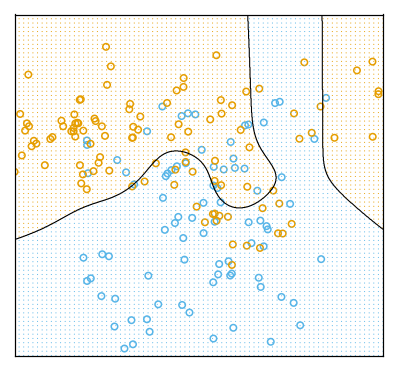

In [10]:
# test prepare_model_plot for the optimal Bayes
prepare_model_plot(optimal_bayes_predict)

In [11]:
from sklearn.linear_model import LinearRegression

In [12]:
# |Let’s look at an example of the linear model in a classiﬁcation context. 
reg = LinearRegression().fit(X_train, Y_train)

In [13]:
# |The ﬁtted values Y-hat are converted to a ﬁtted class variable G-hat according to the rule
# |G-hat =(ORANGE if Y-hat > 0.5, BLUE if Y-hat ≤ 0.5.
def linear_predict(X):
    return 1*(reg.predict(X)>0.5)

In [14]:
# calc the linear model error rate on test and train data
linear_test_error_rate = mean_absolute_error(Y_test, linear_predict(X_test))
linear_train_error_rate = mean_absolute_error(Y_train, linear_predict(X_train))
print(f'The linear model error rate on train data = {linear_train_error_rate}')
print(f'The linear model error rate on test data = {linear_test_error_rate}')

The linear model error rate on train data = 0.255
The linear model error rate on test data = 0.2548


(<matplotlib.figure.Figure at 0x21556b175f8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x21556b39198>)

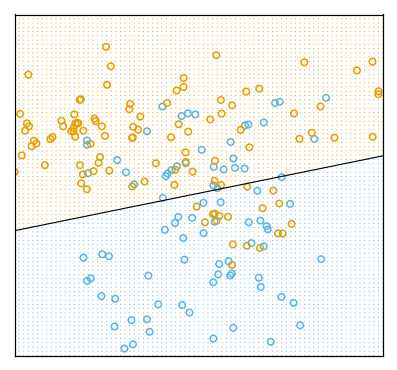

In [15]:
# |The line is the decision boundary deﬁned by x.T @ b = 0.5. The orange shaded region denotes
# |that part of input space classiﬁed as ORANGE, while the blue region is classiﬁed as BLUE. 
prepare_model_plot(linear_predict)

In [16]:
from sklearn.neighbors import KNeighborsClassifier
from hypopt import GridSearch

In [17]:
# |use 15-nearest-neighbor averaging of the binary coded response as the method of ﬁtting. 
# |Thus Y-hat is the proportion of ORANGE’s in the neighborhood, and so assigning class ORANGE 
# |to G-hat if Y-hat > 0.5 amounts to a majority vote in the neighborhood.
knc = KNeighborsClassifier(n_neighbors=15).fit(X_train, Y_train)

(<matplotlib.figure.Figure at 0x21556b3a668>,
 <matplotlib.axes._subplots.AxesSubplot at 0x21556d96fd0>)

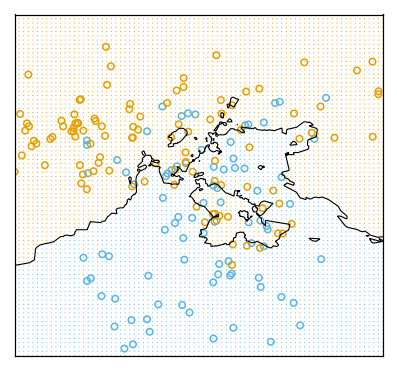

In [18]:
prepare_model_plot(knc.predict)

(<matplotlib.figure.Figure at 0x21556da4710>,
 <matplotlib.axes._subplots.AxesSubplot at 0x21556dfb828>)

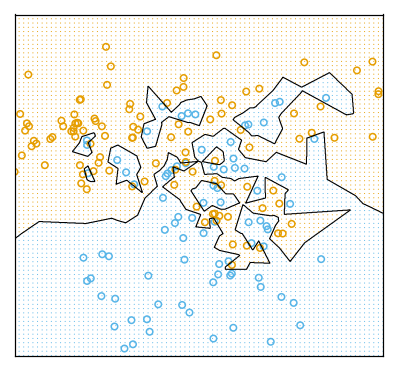

In [19]:
# |The classes are coded as a binary variable (BLUE = 0,ORANGE = 1), 
# |and then predicted by 1-nearest-neighbor classiﬁcation.
knc = KNeighborsClassifier(n_neighbors=1).fit(X_train, Y_train)
prepare_model_plot(knc.predict)

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

In [21]:
class NaturalCubicSplineFeatures():
    def __init__(self, knots, tensor_product=False):
        self.knots = knots
        self.tensor_product=tensor_product
    
    @staticmethod
    def dk(x, xi_k, xi_K):
        return (max(0, x-xi_k)**3) / (xi_K-xi_k)
    
    @staticmethod
    def do_nc_expansion(x, xis):
        X = np.zeros(shape=(x.shape[0], len(xis)))
        for i in range(X.shape[0]):
            X[i, 0] = 1
            X[i, 1] = x[i]
            for k in range(2, len(xis)):
                X[i, k] = NaturalCubicSplineFeatures.dk(x[i], xis[k-2], xis[-1]) - \
                          NaturalCubicSplineFeatures.dk(x[i], xis[-2], xis[-1])
        return X
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        h = []
        for i in range(X.shape[1]):
            h.append(NaturalCubicSplineFeatures.do_nc_expansion(X[:,i], self.knots[i])[:,1:])            
        if self.tensor_product:
            for j in range(h[0].shape[1]):
                for k in range(h[1].shape[1]):
                    h.append(h[0][:,j:j+1]*h[1][:,k:k+1])
        result = np.hstack(h)
        return result

The lrc model error rate on train data = 0.245
The lrc model error rate on test data = 0.2482


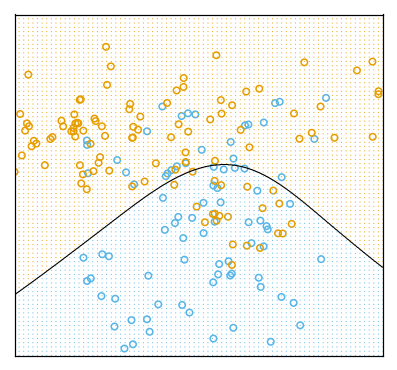

In [24]:
model = Pipeline([('poly', NaturalCubicSplineFeatures([np.array([-2, 0, 1, 3]), np.array([-2, 0, 1, 3])], tensor_product=False)),
                  ('logistic', LogisticRegression())])
lrc = model.fit(X_train, Y_train)
prepare_model_plot(lrc.predict)
lrc_test_error_rate = mean_absolute_error(Y_test, lrc.predict(X_test))
lrc_train_error_rate = mean_absolute_error(Y_train, lrc.predict(X_train))
print(f'The lrc model error rate on train data = {lrc_train_error_rate}')
print(f'The lrc model error rate on test data = {lrc_test_error_rate}')

The lrc model error rate on train data = 0.22
The lrc model error rate on test data = 0.2713


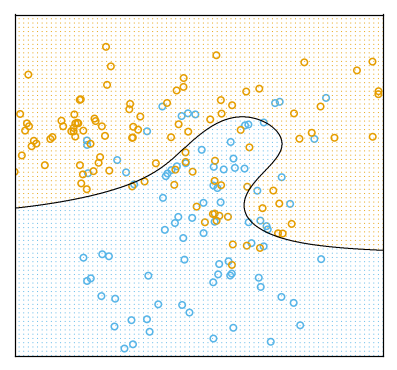

In [25]:
model = Pipeline([('poly', NaturalCubicSplineFeatures([np.array([-2, 0, 1, 3]), np.array([-2, 0, 1, 3])], tensor_product=True)),
                  ('logistic', LogisticRegression())])
lrc = model.fit(X_train, Y_train)
prepare_model_plot(lrc.predict)
lrc_test_error_rate = mean_absolute_error(Y_test, lrc.predict(X_test))
lrc_train_error_rate = mean_absolute_error(Y_train, lrc.predict(X_train))
print(f'The lrc model error rate on train data = {lrc_train_error_rate}')
print(f'The lrc model error rate on test data = {lrc_test_error_rate}')